In [1]:
from stable_baselines3.sac.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import SAC
import logging
import gym
import numpy as np
import os
import matplotlib.pyplot as plt
import DyMat

# add reference libraries here. Current structure will use the relative path from this file
libs = ["../../../OpenIPSL-1.5.0/OpenIPSL/package.mo",
       "../../../OpenIPSL-1.5.0/ApplicationExamples/IEEE9/package.mo"]

# check that all the paths to library package.mo files exist
# DymolaInterface() also checks this but I've found this warning helpful
for lib in libs:
    if not os.path.isfile(lib):
        print(f"Cannot find the library {lib}")

mo_name = "IEEE9.IEEE_9_RL" # name of Modelica model in the Library.Model format
env_entry_point = 'examples:IEEE9Env' # Python package location of RL environment

time_step = 60 # time delta in seconds
positive_reward = 1
negative_reward = -100 # penalize RL agent for is_done
log_level = 0
default_action = [0,0]

# these config values are passed to the model specific environment class
# mo_name and libs are passed on to the DymolaBaseEnv class
config = {
    'mo_name': mo_name,
    'libs': libs,
#     'actions': actions,
#     'states': states,
    'time_step': time_step,
    'positive_reward': positive_reward,
    'negative_reward': negative_reward,
    'log_level': log_level,
    'default_action': default_action,
    'method':'Dassl'
}

# enable the model specific class as an OpenAI gym environment
from gym.envs.registration import register
env_name = "MicrogridEnv-v1"

register(
    id=env_name,
    entry_point=env_entry_point,
    kwargs=config
)

In [2]:
# create the environment. this will run an initial step and must return [True, [...]] or something is broken
# TODO: create error handling/warnings if simulations don't work (i.e. returns [False], [...])
env = gym.make(env_name)

resetting dymola...
dymola has been reset
the model will be reset
the model has been reset


C:\Users\Aisling\.conda\envs\myenv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
#env.reset()
for i in range(5):
    action = env.action_space.sample()
    env.step(action)


!!!! 298851.80722850934
0.7642801978388789
0.800411930664469
0.8105947019603479
0.8124774129083221
0.8127079982508658


In [4]:
env.dymola=None
env.reset_dymola()
env.dymola.simulateModel(env.model_name)

resetting dymola...
dymola has been reset


True

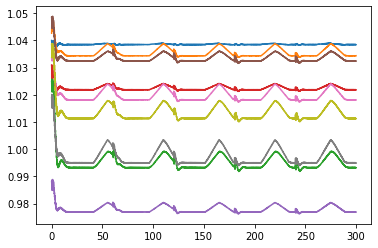

In [5]:
for i in range(1,10):
    plt.plot(env.debug_data['iEEE_9.my_time'],env.debug_data[f'iEEE_9.B{i}.V'])

In [6]:
env.dymola.simulateExtendedModel(stopTime=1,  finalNames=env.model_output_names)

[True,
 [1.0384633541107178,
  1.0471065044403076,
  1.0245040655136108,
  1.0299190282821655,
  0.9884110689163208,
  1.0480122566223145,
  1.0353033542633057,
  1.019004225730896,
  1.0377392768859863,
  1.7992879202632255,
  1.1640660266971463,
  1.1827599778248716,
  -0.0059214089545204275,
  2.4885772373922777]]